# Ch1

In [1]:
from fastai.structured import *
from fastai.imports import *

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

/Users/sud/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Preprocessing

In [2]:
df_raw = pd.read_csv('bluebook-for-bulldozers/Train.csv', parse_dates=['saledate'])

/Users/sud/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_raw.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [5]:
add_datepart(df_raw, 'saledate')  # make more columns for a 'date' type column

In [6]:
%time train_cats(df_raw)  # convert categorical variables to type 'category' in pandas

CPU times: user 11.5 s, sys: 592 ms, total: 12.1 s
Wall time: 12.2 s


## The most basic model

In [7]:
df, y, nas = proc_df(df_raw, 'SalePrice')  # without 1hot encoding        

In [8]:
os.makedirs('tmp', exist_ok=True)
df.to_feather('tmp/bulldozers-clean')
df = pd.read_feather('tmp/bulldozers-clean')

In [42]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # Same size as test set
n_trn = len(df)-n_valid

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

len(X_train), len(X_valid), len(y_train), len(y_valid)

(389125, 12000, 389125, 12000)

In [10]:
def rmse(actual, pred): return np.sqrt(np.mean((pred-actual)**2))

def r2_score(actual, pred):
    return 1 - rmse(actual, pred)/ rmse(actual, np.mean(actual))

def print_score(m):
    print('RMSE Train: ', rmse(m.predict(X_train), y_train) * 100)
    print('RMSE Valid: ', rmse(m.predict(X_valid), y_valid) * 100)
    print(' R2  Train: ', m.score(X_train, y_train) * 100)
    print(' R2  Valid: ', m.score(X_valid, y_valid) * 100)
    if hasattr(m, 'oob_score_'): 
        print('   OOB    : ', m.oob_score_ * 100)

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# Classifier -> predict categorical
# Regression -> predict continuous

m = RandomForestRegressor(n_jobs=-1)  # Bootstraped model
%time m.fit(X_train, y_train)
print_score(m)

/Users/sud/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 36s, sys: 736 ms, total: 1min 37s
Wall time: 30.9 s
RMSE Train:  9.056705037167397
RMSE Valid:  24.663547133282925
 R2  Train:  98.28574559766966
 R2  Valid:  89.13676814741088


In [40]:
m.predict(X_valid), m.score(X_valid, y_valid), np.mean(m.predict(X_valid)), np.std(m.predict(X_valid))

(array([9.17702, 9.16897, 9.25441, ..., 9.44273, 9.31048, 9.31048]),
 0.8913676814741088,
 10.012604788545604,
 0.6932527067952876)

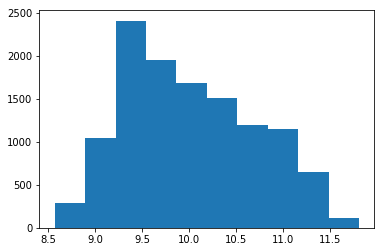

In [41]:
plt.hist(m.predict(X_valid));

## Tree interpreter

In [15]:
from treeinterpreter import treeinterpreter as ti

In [16]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 2, 3232, 1111, 0, 69, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9,
        37, 16, 3, 259, False, False, False, False, False, False, 1284595200, False, False]], dtype=object)

In [17]:
prediction, bias, contributions = ti.predict(m, row)

In [18]:
prediction, bias, contributions  # actual pred, avg y, contribution of each col

(array([[9.17702]]),
 array([10.10561]),
 array([[-0.00458, -0.00525, -0.01306,  0.00215,  0.     ,  0.02487, -0.01061,  0.     , -0.0387 ,  0.01831,
          0.00062,  0.00822,  0.     , -0.82742, -0.05853, -0.01731,  0.     ,  0.     ,  0.     , -0.00402,
          0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         -0.01033,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.10543,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     , -0.01322,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
          0.     , -0.00175, -0.00211, -0.01089,  0.00227, -0.01319,  0.00111,  0.00144,  0.     ,  0.     ,
          0.     ,  0.     ,  0.     , -0.06203,  0.     ,  0.     ]]))

In [22]:
idxs = np.argsort(contributions[0])
[o for o in zip(X_valid.columns[idxs], X_valid.iloc[0][idxs], contributions[0][idxs])]
# Feature,    Value in the row,    Contribution

[('ProductSize', 5, -0.8274220325463135),
 ('saleElapsed', 1284595200, -0.06203234395696224),
 ('fiProductClassDesc', 17, -0.05853101269602874),
 ('fiModelDesc', 3232, -0.03869971271031911),
 ('state', 35, -0.0173145133678684),
 ('Thumb', 3, -0.013220002817828735),
 ('saleDayofweek', 3, -0.013191288376810207),
 ('ModelID', 665, -0.013058728721169467),
 ('saleWeek', 37, -0.010886498182733462),
 ('MachineHoursCurrentMeter', 3726.0, -0.010611873624563728),
 ('Hydraulics', 12, -0.010326891524111658),
 ('MachineID', 2300944, -0.005253317499041366),
 ('SalesID', 4364751, -0.004577250607535888),
 ('Enclosure', 1, -0.004021224214094232),
 ('saleMonth', 9, -0.002108044422787181),
 ('saleYear', 2010, -0.001754063800818706),
 ('saleIs_quarter_end', False, 0.0),
 ('Grouser_Tracks', 0, 0.0),
 ('Hydraulics_Flow', 0, 0.0),
 ('saleIs_year_start', False, 0.0),
 ('Track_Type', 2, 0.0),
 ('Undercarriage_Pad_Width', 19, 0.0),
 ('Stick_Length', 29, 0.0),
 ('saleIs_year_end', False, 0.0),
 ('saleIs_month_st

In [23]:
bias + contributions[0].sum() , prediction

(array([9.17702]), array([[9.17702]]))

## Single tree

RMSE Train:  52.828345841347044
RMSE Valid:  58.29885446314813
 R2  Train:  41.673105933113504
 R2  Valid:  39.302889562486584


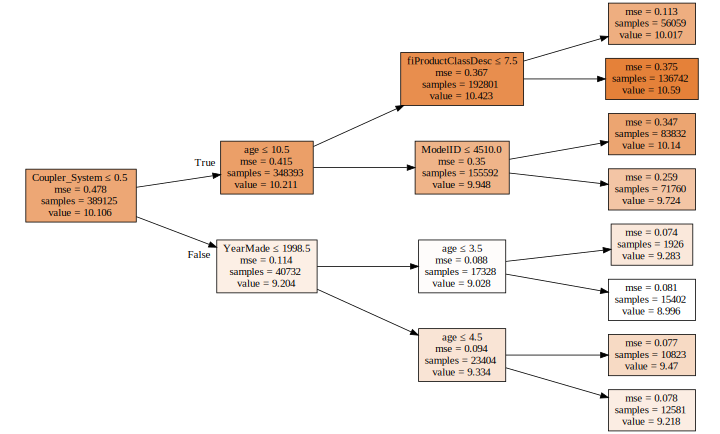

In [85]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

draw_tree(m.estimators_[0], X_train, precision=3)

In [48]:
np.mean((y_train-np.mean(y_train))**2)

0.4784815253719107

In [49]:
np.mean(y_train)

10.105515927938027

# Ch2

## Subsampling for each tree

- Each tree is trained on a different random subset
- It trains faster and is specialized in its subset
- Given enough trees, the forest will have the knowledge of the whole dataset

*If using set_rf_samples (custom defined), set oob_score=False (defined in sklearn)*

In [50]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')  # without 1hot encode
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

set_rf_samples(20000)  # Subsampled model

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 40.9 s, sys: 1.2 s, total: 42.1 s
Wall time: 19.7 s
RMSE Train:  22.715828019379185
RMSE Valid:  26.250517254143762
 R2  Train:  89.21569976594326
 R2  Valid:  87.69380748559446
   OOB    :  88.06373478217941


In [51]:
# Variance in the predictions

def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 135 ms, sys: 107 ms, total: 242 ms
Wall time: 2.1 s


(9.3169592339384, 0.2857970919729438)

In [52]:
reset_rf_samples()

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)  # Bootstraped model
%time m.fit(X_train, y_train)  
print_score(m)

CPU times: user 7min, sys: 5.13 s, total: 7min 5s
Wall time: 2min 15s
RMSE Train:  7.837953377075217
RMSE Valid:  23.792844798830053
 R2  Train:  98.71607345563751
 R2  Valid:  89.89024298964183
   OOB    :  90.83791380817037


In [53]:
# Extra arguments

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                      max_features=0.5, n_jobs=-1, oob_score=True)  # Bootstraped model
%time m.fit(X_train, y_train) 
print_score(m)

CPU times: user 3min 13s, sys: 2.6 s, total: 3min 16s
Wall time: 1min 6s
RMSE Train:  11.906626005969184
RMSE Valid:  22.80435877833463
 R2  Train:  97.03713235875033
 R2  Valid:  90.71282339508942
   OOB    :  91.19405377806355


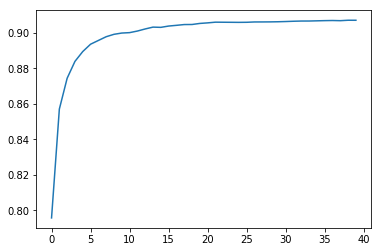

In [54]:
from sklearn import metrics

preds = np.stack([tree.predict(X_valid) for tree in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

# Ch 3

In [18]:
set_rf_samples(50000)  # Subsampled model
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 45.8 s, sys: 1.25 s, total: 47 s
Wall time: 22.5 s
RMSE Train:  20.59603112810358
RMSE Valid:  24.9092548465246
 R2  Train:  91.134527129337
 R2  Valid:  88.91924261963466
   OOB    :  89.43346396123268


In [19]:
# Variance in the predictions

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 126 ms, sys: 92.3 ms, total: 218 ms
Wall time: 1.66 s


(9.303845202176808, 0.3762800919674485)

## Feature Importance

In [55]:
fi = rf_feat_importance(m, df_trn); fi[:10]  # Gini importance without 1hot on a subsampled model

,cols,imp
5,YearMade,0.169350
37,Coupler_System,0.121473
13,ProductSize,0.088561
14,fiProductClassDesc,0.086741
2,ModelID,0.055512
63,saleElapsed,0.055414
38,Grouser_Tracks,0.049017
10,fiSecondaryDesc,0.046212
12,fiModelDescriptor,0.037809
8,fiModelDesc,0.034463


In [56]:
def shuffle_col(colname, df):
    df_temp = df.copy()
    df_temp[colname] = np.random.permutation(df_temp[colname].values)
    return df_temp
        
def feature_importance(model, df):
    pred_actual = model.predict(df)
    colnames = [col for col in df.columns]
    imp = [(1 - r2_score(pred_actual, model.predict(shuffle_col(col, df)))) for col in df.columns]
    
    res = {'cols': colnames, 'imp': imp}
    fi = pd.DataFrame.from_dict(res).sort_values('imp', ascending=False).round(6)
    return fi

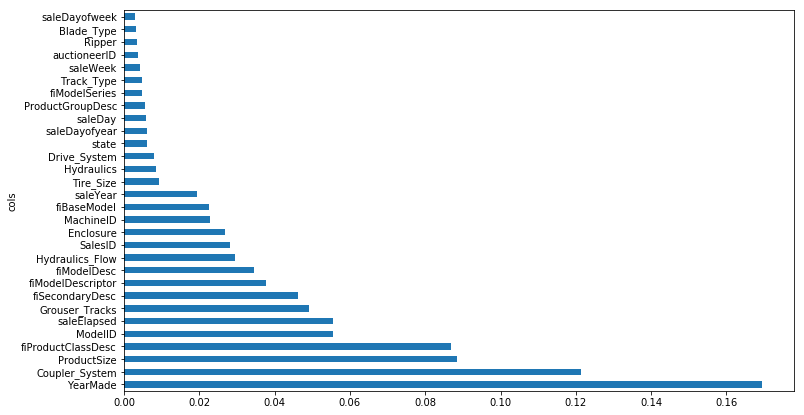

In [57]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [59]:
fi

,cols,imp
5,YearMade,0.169350
37,Coupler_System,0.121473
13,ProductSize,0.088561
14,fiProductClassDesc,0.086741
2,ModelID,0.055512
63,saleElapsed,0.055414
38,Grouser_Tracks,0.049017
10,fiSecondaryDesc,0.046212
12,fiModelDescriptor,0.037809
8,fiModelDesc,0.034463


In [60]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

# Ch 4

In [61]:
# Removed non important features

df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

set_rf_samples(50000)   # Subsampled model

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                       max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train:  20.720376603129303
RMSE Valid:  24.570217524283752
 R2  Train:  91.02715603822325
 R2  Valid:  89.21882794959521
   OOB    :  89.39924413165484


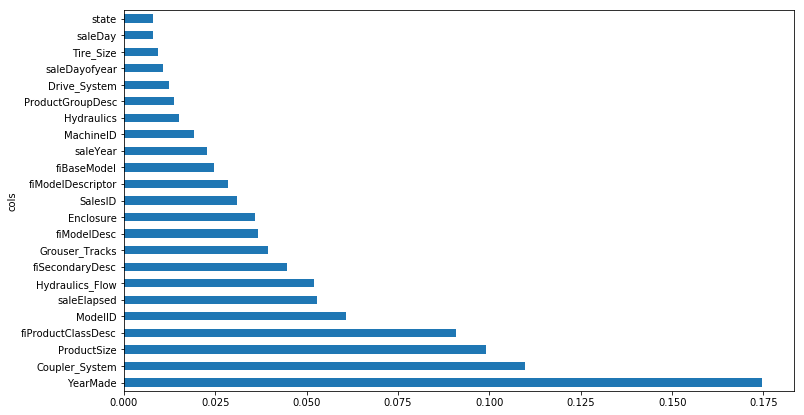

In [62]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

## One hot encoding

In [28]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)  # 1hot encoded
X_train, X_valid = split_vals(df_trn2, n_trn)  

set_rf_samples(50000) # Subsampled model

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1, oob_score=True) 
%time m.fit(X_train, y_train) 
print_score(m)

CPU times: user 1min 37s, sys: 5.33 s, total: 1min 43s
Wall time: 52.3 s
RMSE Train:  20.715520905304462
RMSE Valid:  25.403501482034084
 R2  Train:  91.031361011388
 R2  Valid:  88.47515383436112
   OOB    :  89.26499452504983


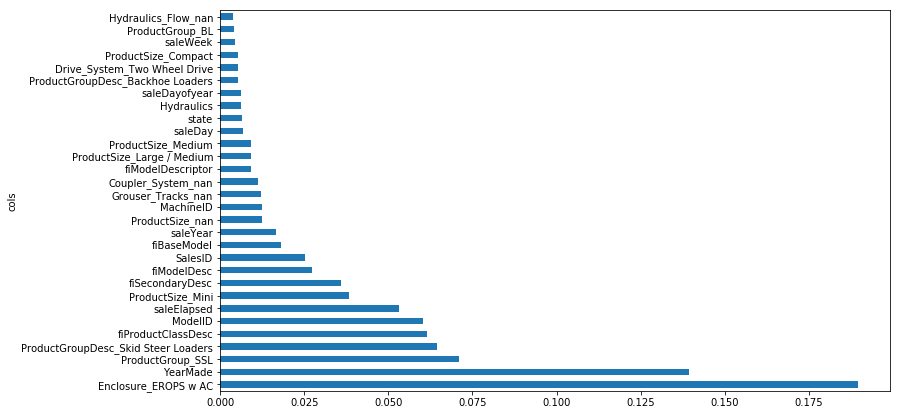

In [30]:
fi = rf_feat_importance(m, df_trn2)  # Importance with 1hot on subsampled model
plot_fi(fi[:30]);

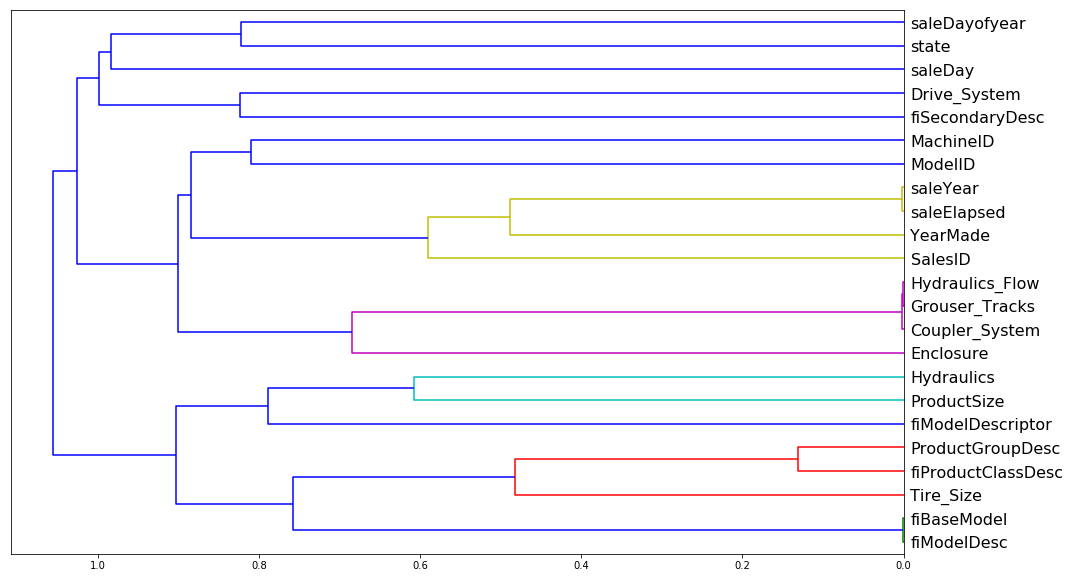

In [63]:
from scipy.cluster import hierarchy as hc

def plot_dendogram(df):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)  # Similarity between features
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(16,10))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
    plt.show()

plot_dendogram(df_keep)  # Plot without 1hot after removing the non important features

In [64]:
set_rf_samples(50000)  # Subsampled model

def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_ * 100

In [65]:
get_oob(df_keep)  # Baseline

89.03929035253717

In [68]:
for c in ['saleYear', 'saleElapsed', 'Grouser_Tracks', 'Hydraulics_Flow',
          'fiModelDesc', 'fiBaseModel']:
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 88.96577294296006
saleElapsed 88.72699565865227
Grouser_Tracks 89.02477486920333
Hydraulics_Flow 88.98468803187907
fiModelDesc 88.93420811313398
fiBaseModel 88.91058697856653


In [69]:
to_drop = ['saleYear', 'Hydraulics_Flow', 'fiBaseModel']
get_oob(df_keep.drop(to_drop, axis=1))

88.89865421652972

In [41]:
# Dropped similar features

df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [42]:
reset_rf_samples()  # Bootstraped model

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 45s, sys: 922 ms, total: 1min 46s
Wall time: 30.4 s
RMSE Train:  12.51548564415119
RMSE Valid:  22.79049206209574
 R2  Train:  96.72636512376931
 R2  Valid:  90.72411452493563
   OOB    :  90.86147528243829


## Partial dependence

In [70]:
set_rf_samples(50000)  # Subsampled model

df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)  # 1hot encoded
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
%time m.fit(X_train, y_train);

CPU times: user 1min 15s, sys: 1.6 s, total: 1min 16s
Wall time: 31.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

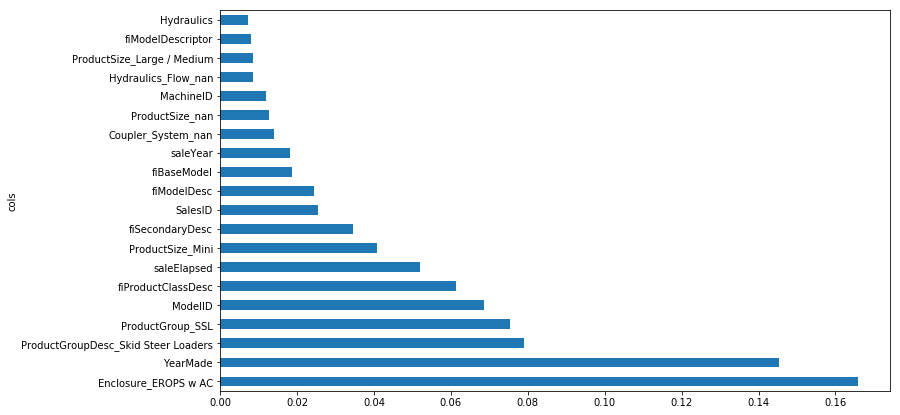

In [71]:
fi = rf_feat_importance(m, df_trn2)  # Importance with 1hot on subsampled model
plot_fi(fi[:20]);

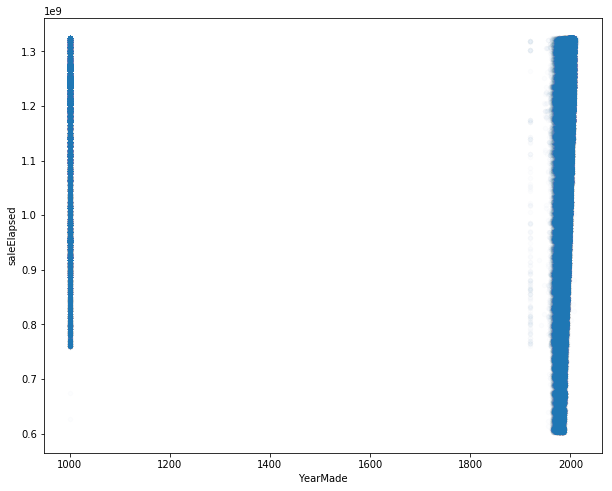

In [72]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));  # Found a data error

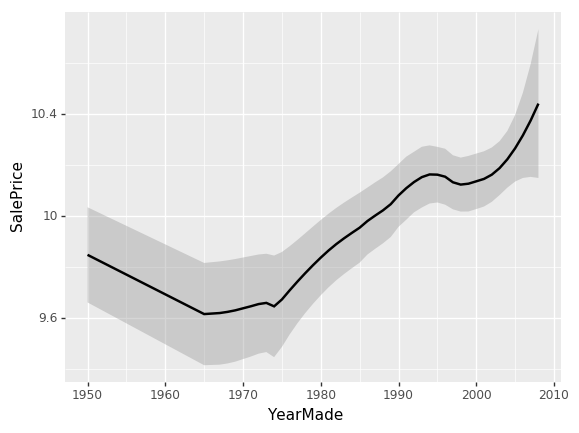

<ggplot: (-9223372029283465447)>

In [97]:
from plotnine import *

x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)  # sample 500 pts excluding years with wrong year=1000
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [80]:
from pdpbox import pdp
from plotnine import *

x = get_sample(X_train[X_train.YearMade>1930], 500)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

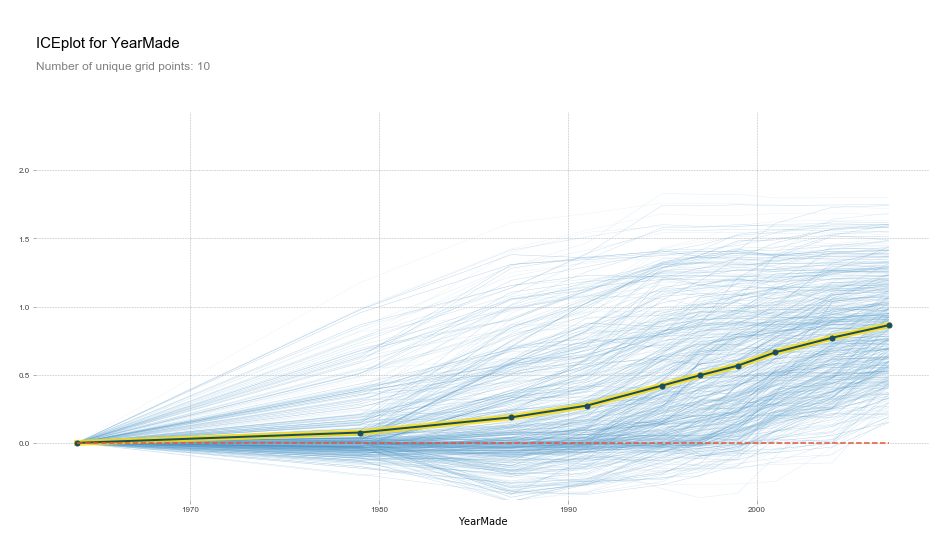

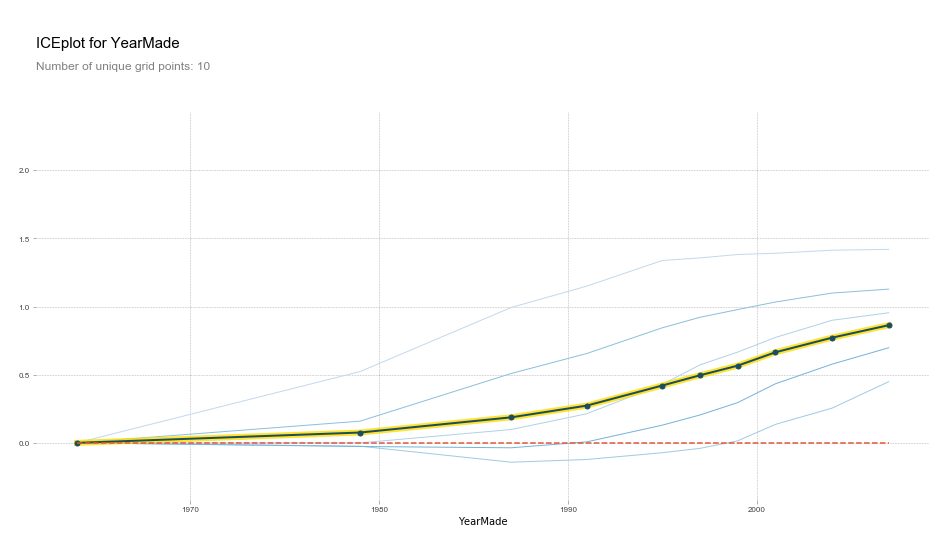

In [81]:
# In the sample 'x', if we replace all values of YearMade with val on x axis,
# predict the saleprice (y axis) using our trained model
# No of blue lines = No of vals in sample x

plot_pdp('YearMade')
plot_pdp('YearMade', 5)

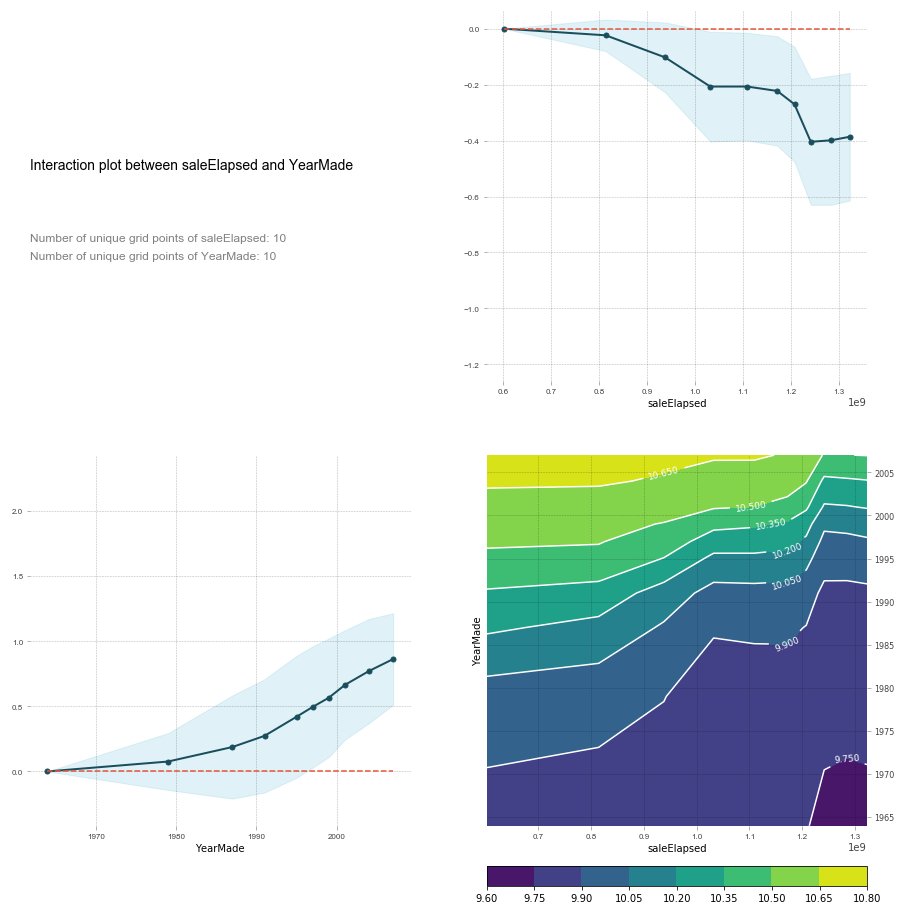

In [82]:
# ~/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/pdpbox/pdp.py
# Edited the library to fix a bug in python3.6/site-packages/pdpbox/pdp.py
# ax.clabel(c2, contour_label_fontsize=9, inline=1)
# to
# ax.clabel(c2, fontsize=9, inline=1)

# Show how 2 features interact with each other
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

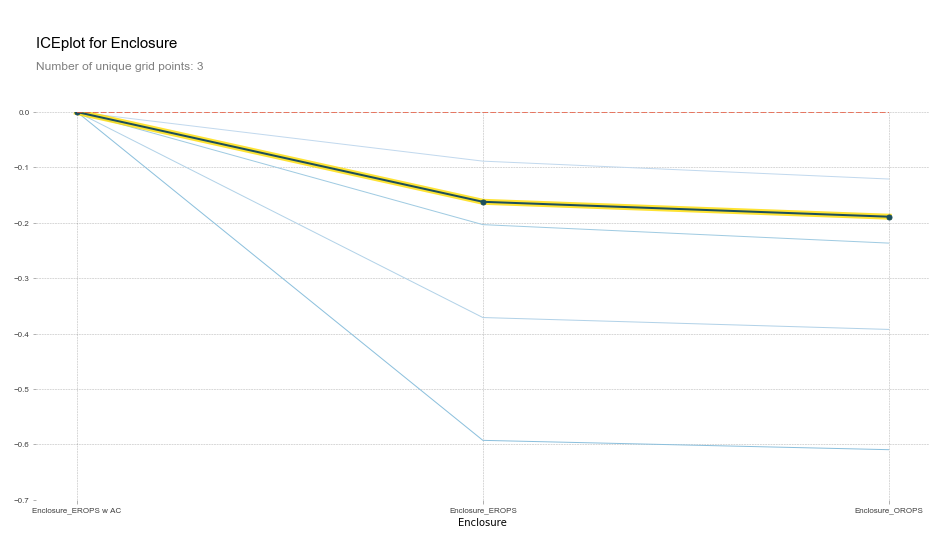

In [83]:
# If you have a categorical variable, you can pass it in like this
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 
         'Enclosure_OROPS'], 5, 'Enclosure')

In [84]:
# Creating a new feature

df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

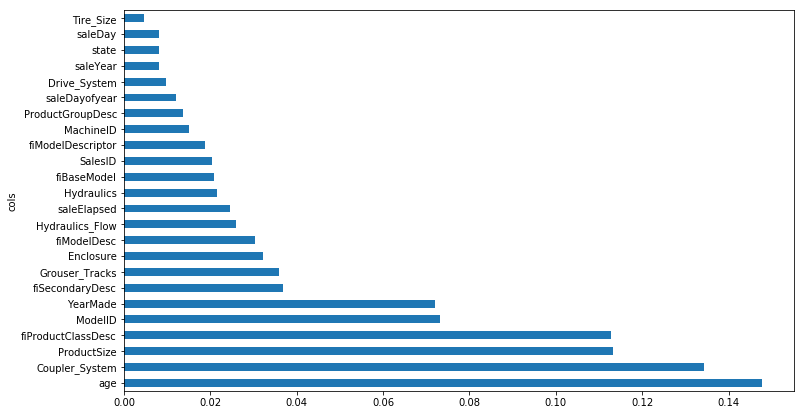

In [85]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                          max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Ch 5

## Removing time dependency

In [112]:
# Use 'is_validation_set' as a column
# If you can predict it successfully, the dataset is time dependent

df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

1.0

In [113]:
# This will give you the most time dependent cols
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.790910
5,saleElapsed,0.131595
13,MachineID,0.036794
15,saleYear,0.027685
20,saleDayofyear,0.004387
9,fiModelDesc,0.001826
14,fiBaseModel,0.001819
4,ModelID,0.001442
0,YearMade,0.001390
1,Coupler_System,0.000393


In [114]:
x.drop(['SalesID', 'saleElapsed', 'MachineID'], axis=1, inplace=True)

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9878142723589903

In [115]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
12,saleYear,0.304906
17,saleDayofyear,0.272887
18,saleDay,0.058173
4,ModelID,0.051130
16,state,0.042714
8,fiModelDesc,0.035032
0,YearMade,0.032792
11,fiBaseModel,0.028507
20,age,0.027576
10,Enclosure,0.025596


In [116]:
set_rf_samples(50000)

X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train:  20.598653998888842
RMSE Valid:  24.674589262576905
 R2  Train:  91.1322689787001
 R2  Valid:  89.12703880376253
   OOB    :  89.49264666804578


In [117]:
feats = ['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
            max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
RMSE Train:  20.71356098138956
RMSE Valid:  24.308051652582495
 R2  Train:  91.03305800163854
 R2  Valid:  89.44767216975238
   OOB    :  89.43400060217263
saleElapsed
RMSE Train:  20.890887335430993
RMSE Valid:  24.88846959555533
 R2  Train:  90.87887095907314
 R2  Valid:  88.93772733401497
   OOB    :  89.23978474869797
MachineID
RMSE Train:  20.535980521583205
RMSE Valid:  24.24983893050512
 R2  Train:  91.1861488141042
 R2  Valid:  89.4981529075756
   OOB    :  89.63543874504691
age
RMSE Train:  20.737057391642864
RMSE Valid:  24.617037609417547
 R2  Train:  91.01270317741019
 R2  Valid:  89.17770040701055
   OOB    :  89.37876843288556
YearMade
RMSE Train:  20.680872250089894
RMSE Valid:  24.72467978514592
 R2  Train:  91.06133770385179
 R2  Valid:  89.08284879789103
   OOB    :  89.43577141081579
saleDayofyear
RMSE Train:  20.71406874842798
RMSE Valid:  24.241474232051598
 R2  Train:  91.03261836951606
 R2  Valid:  89.50539663681182
   OOB    :  89.43931809578794


In [118]:
reset_rf_samples()

df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
               max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 24s, sys: 1.54 s, total: 1min 25s
Wall time: 30.7 s
RMSE Train:  13.705755407064165
RMSE Valid:  21.686906185907002
 R2  Train:  96.07408601340961
 R2  Valid:  91.60069841015492
   OOB    :  91.01354851975675


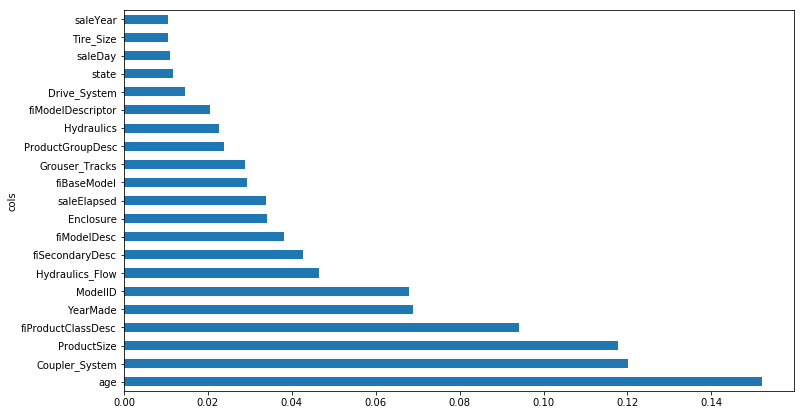

In [119]:
plot_fi(rf_feat_importance(m, df_subs));

In [120]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, 
          n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 24s, sys: 14.3 s, total: 6min 39s
Wall time: 2min 23s
RMSE Train:  7.988757529801392
RMSE Valid:  20.970587410494318
 R2  Train:  98.6661920369788
 R2  Valid:  92.14639299338035
   OOB    :  91.52258361394837


In [176]:
os.makedirs('tmp', exist_ok=True)
df.to_feather('tmp/bulldozers-final')

In [ ]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [ ]:
%load_ext Cython

In [ ]:
def fib1(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%%cython
def fib2(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b

In [ ]:
%%cython
def fib3(int n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = t + b

In [ ]:
%timeit fib1(50)
%timeit fib2(50)
%timeit fib3(50)